# Synthetic Properties:
This file is mostly createt by Claude, with some modifications


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('01_framingham_clean.csv')
df.sample(5)

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,education_1.0,education_2.0,education_3.0,education_4.0,TenYearCHD
161,1,41,1,20.0,1.0,0,1,0,244.0,139.0,86.0,31.0,60.0,67.0,0,0,0,1,0
364,1,59,1,15.0,0.0,0,0,0,212.0,106.0,66.0,26.0,85.0,117.0,0,1,0,0,0
242,0,45,0,0.0,0.0,0,0,0,246.0,134.0,81.0,22.0,85.0,76.0,0,0,1,0,0
1276,0,59,1,20.0,0.0,0,1,0,270.0,175.0,95.0,30.0,95.0,76.0,1,0,0,0,0
3823,0,65,0,0.0,0.0,0,1,0,223.0,158.0,90.0,27.0,85.0,93.0,1,0,0,0,1


In [4]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.random.seed(42)  # For reproducibility

def weighted_odds_ratio(df, col, target):
    # Apply class weights inversely proportional to class frequency
    class_weights = 1 / df[target].value_counts(normalize=True)
    weighted_cm = confusion_matrix(df[col], df[target], sample_weight=df[target].map(class_weights))
    
    # Recalculate odds ratio using weighted confusion matrix
    TN, FP, FN, TP = weighted_cm.ravel()
    weighted_or = (TP * TN) / (FP * FN) if TN != 0 and FN != 0 else np.nan
    return weighted_or

In [19]:
def generate_synthetic_feature(df, target_col, baseline_risk, odds_ratio):
    # Calculate exposure probabilities
    baseline_odds = baseline_risk / (1 - baseline_risk)
    exposure_odds = baseline_odds * odds_ratio
    exposure_risk = exposure_odds / (1 + exposure_odds)
    
    # Generate synthetic feature
    synthetic_feature = df[target_col].apply(
        lambda x: np.random.choice([False, True], p=[1-exposure_risk, exposure_risk]) if x == 1 
        else np.random.choice([False, True], p=[1-baseline_risk, baseline_risk])
    )
    
    return synthetic_feature

In [6]:
# Calculate odds ratios for features against TenYearCHD
def calculate_odds_ratio(df, feature, target):
    contingency_table = pd.crosstab(df[feature], df[target])
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    return odds_ratio

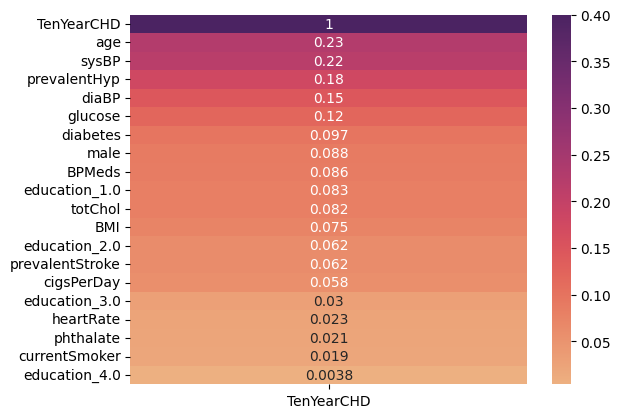

In [21]:
# Define the odds ratios for each EDC exposure
odds_ratios = {
    'pcb': 1.28, # polychlorinated biphenyl  (OR=1.28; 95%CI: 1.17–1.39)
    'bpa': 1.19, #  bisphenol   (OR=1.19, 95% CI: 1.03–1.37)
    'organochlorine_pesticide': 1.12, # organo-chlorine pesticide  (OR=1.12, 95% CI: 1.00–1.24)
    'phthalate': 1.11, # (OR=1.11, 95% CI: 1.06–1.17)
    'testvalue' : 4
}

col = 'phthalate'

odds_ratio = odds_ratios[col]  # Odds ratio
baseline_risk = 0.8

df[col] = generate_synthetic_feature(df = df, target_col= 'TenYearCHD', baseline_risk= baseline_risk, odds_ratio = odds_ratio)

sns.heatmap(df.corr().abs()[['TenYearCHD']].sort_values(by='TenYearCHD', ascending=False), cmap = 'flare', vmax = 0.4, annot = True)
plt.show()

In [16]:
for col in df.columns:
    print(type(df[col][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.bool_'>


In [20]:
# Get odds ratios for all numeric/categorical features
feature_odds_ratios = {}
for col in df.columns:
    if col != 'TenYearCHD':
        try:
            odds_ratio = calculate_odds_ratio(df, col, 'TenYearCHD')
            feature_odds_ratios[col] = odds_ratio
        except:
            pass

# Sort and print odds ratios
sorted_odds_ratios = dict(sorted(feature_odds_ratios.items(), key=lambda x: abs(x[1]-1), reverse=True))
for feature, or_value in sorted_odds_ratios.items():
    print(f"{feature}: {or_value:.2f}")

prevalentStroke: 4.45
diabetes: 3.39
BPMeds: 2.88
prevalentHyp: 2.67
male: 1.63
education_1.0: 1.58
education_2.0: 0.67
education_3.0: 0.79
currentSmoker: 1.11
education_4.0: 0.97
phthalate: 0.98
